In [1]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
background-color: transparent !important;
}
/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
--jp-widgets-color: var(--vscode-editor-foreground);
--jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from sympy import *
import sys
sys.path.append('../')
from utils.fehler_gauss import fehler_gauss

In [3]:
# sheets importieren
sheet_names = [
    "Na22",
    "Cs",
    "Co",
    "Schutz",
    "Nackt",
    "K2CO3",
    "Melke die Molke",
    "Uranoxid",
    "Thor",
    "Pilze nur Pilze",
]
sheets = [pd.read_excel("RAD.xlsx", sheet_name=name) for name in sheet_names]
sheets = (
    pd.concat(dict(zip(sheet_names, sheets)))
    .drop(columns=["n_A#2", "N_A#2", "n_A#3", "N_A#3"])
    .rename(columns={"n_A": "Channel", "N_A": "Events"})
    .reset_index()
    .set_index(["level_0", "Channel"])
    .drop(columns="level_1")
)
sheets

Events
level_0         Channel        
Na22            0             6
                1            14
                2             9
                3             7
                4             3
...                         ...
Pilze nur Pilze 1019          0
                1020          0
                1021          0
                1022          0
                1023        984

[10240 rows x 1 columns]

## Kalibrierkurven

In [4]:
def get_peaks(series, prominence=100):
    # peaks finden
    peaks = find_peaks(sheets.loc[series, "Events"], prominence=prominence)[0]
    # unsicherheiten bestimmen
    widths = peak_widths(sheets.loc[series, "Events"], peaks)[0]
    peaks = pd.DataFrame(
        {
            "Channel": peaks,
            "Events": sheets.loc[series, "Events"].iloc[peaks],
            "Width": widths,
        }
    )
    return peaks

def peak_plot(series, peaks):
    plt.plot(sheets.loc[series, "Events"])
    plt.plot(peaks["Channel"], peaks["Events"], "x")
    plt.grid(True)
    plt.xlabel("Channel")
    plt.ylabel("Events")

,Channel,Events,Width,Energy
Channel,,,,
186,187.1,900,4.5,511
446,447.5,164,3.7,1275


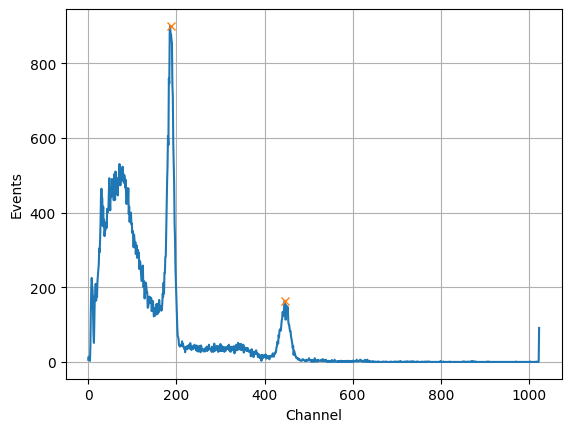

In [5]:
peaks = get_peaks("Na22")
na_peaks = peaks.drop(index=[8, 30])
na_peaks["Energy"] = [511, 1275, 1787]
na_peaks["Width"] = [23.4, 4.5, 3.7]
na_peaks["Channel"] = [62.2, 187.1, 447.5]
na_peaks = na_peaks.drop(index=[71])
na_peaks["Energy"] = [511, 1275]
peak_plot("Na22", na_peaks)
na_peaks

,Channel,Events,Width,Energy
Channel,,,,
413,417.1,30,0.0,1173
466,466.7,28,4.7,1333


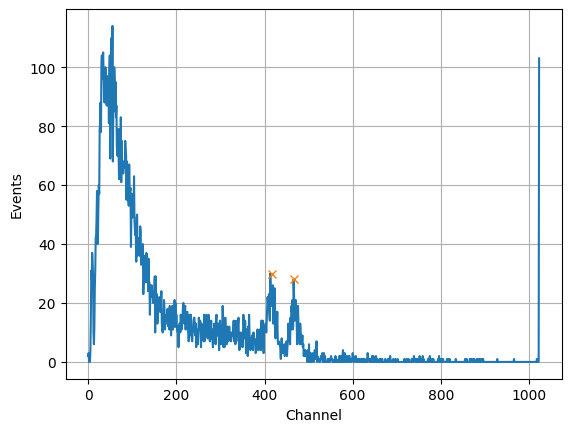

In [6]:
peaks = get_peaks("Co", prominence=25)
co_peaks = peaks.drop(index=[9, 34, 59])
co_peaks["Energy"] = [1173, 1333, 2506]
co_peaks["Channel"] = [38.2, 417.1, 466.7]
co_peaks["Width"] = [0, 0, 4.7]
co_peaks = co_peaks.drop(index=55)
co_peaks["Energy"] = [1173, 1333]
peak_plot("Co", co_peaks)
co_peaks

,Channel,Events,Width,Energy
Channel,,,,
242,241.5,4810,4.7,662


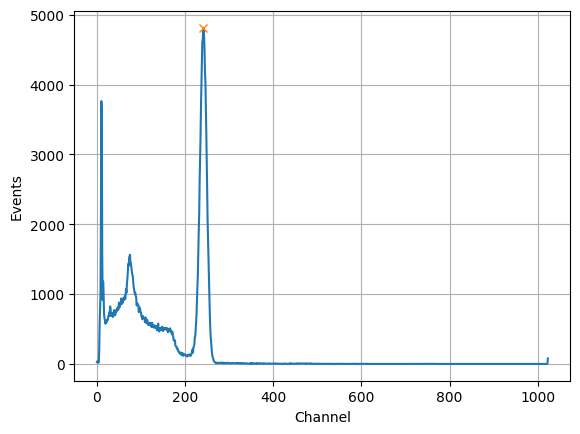

In [7]:
cs_peaks = get_peaks("Cs", prominence=100)
cs_peaks = cs_peaks.drop(index=[10, 14, 30, 75])
cs_peaks["Energy"] = [662]
cs_peaks["Width"] = [4.7]
cs_peaks["Channel"] = [241.5]
peak_plot("Cs", cs_peaks)
cs_peaks

In [8]:
peaks = pd.concat([na_peaks, co_peaks]).sort_index()
peaks

,Channel,Events,Width,Energy
Channel,,,,
186,187.1,900,4.5,511
413,417.1,30,0.0,1173
446,447.5,164,3.7,1275
466,466.7,28,4.7,1333


In [9]:
def linear(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear, peaks["Channel"], peaks["Energy"])
popt, pcov

(array([  2.92733499, -38.21636309]),
 array([[ 1.31849922e-03, -5.00502212e-01],
        [-5.00502212e-01,  2.06689156e+02]]))

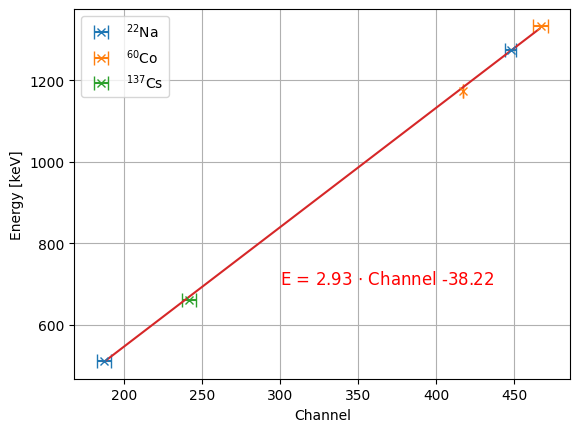

In [10]:
Channels = np.arange(peaks["Channel"].min(), peaks["Channel"].max(), 1)
Energy = linear(Channels, *popt)
plt.errorbar(na_peaks["Channel"], na_peaks["Energy"], xerr=na_peaks["Width"], fmt="x", capsize=5, label=r"$^{22}$Na")
plt.errorbar(co_peaks["Channel"], co_peaks["Energy"], xerr=co_peaks["Width"], fmt="x", capsize=5, label=r"$^{60}$Co")
plt.errorbar(cs_peaks["Channel"], cs_peaks["Energy"], xerr=cs_peaks["Width"], fmt="x", capsize=5, label=r"$^{137}$Cs")
plt.plot(Channels, Energy)
plt.grid(True)
plt.ylabel("Energy [keV]")
plt.xlabel("Channel")
plt.annotate(r"E = " + f"{popt[0]:.2f}" + r" $\cdot$ Channel " + f"{popt[1]:.2f}", (300, 700), fontsize=12, c="r")
plt.legend()

In [11]:
def e_channel(channel):
    return linear(channel, *popt)

## Untergrund

<Axes: xlabel='Channel'>

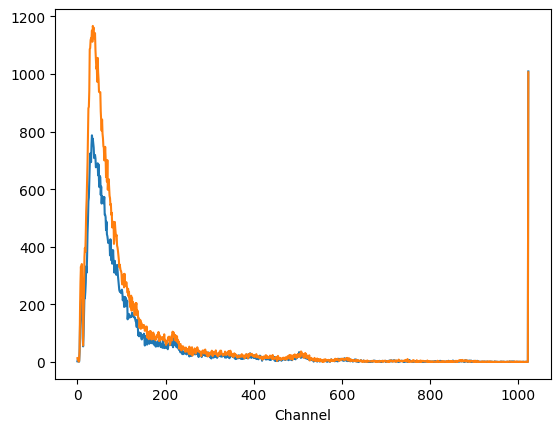

In [12]:
untergrund_mit_blei = sheets.loc["Schutz", "Events"]
untergrund_ohne_blei = sheets.loc["Nackt", "Events"]
untergrund_mit_blei.plot(label="Mit Blei")
untergrund_ohne_blei.plot(label="Ohne Blei")

<Axes: xlabel='Channel'>

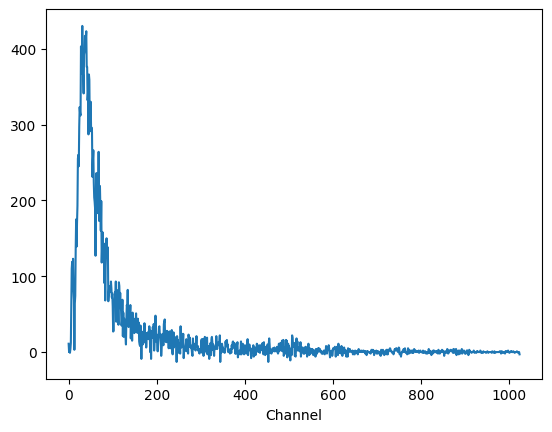

In [13]:
(untergrund_ohne_blei - untergrund_mit_blei).plot()

## Kaliumprobe

uncertainty energy peak: 31.70637357768601


(np.float64(1418.627106832025), np.float64(1482.039853987397))

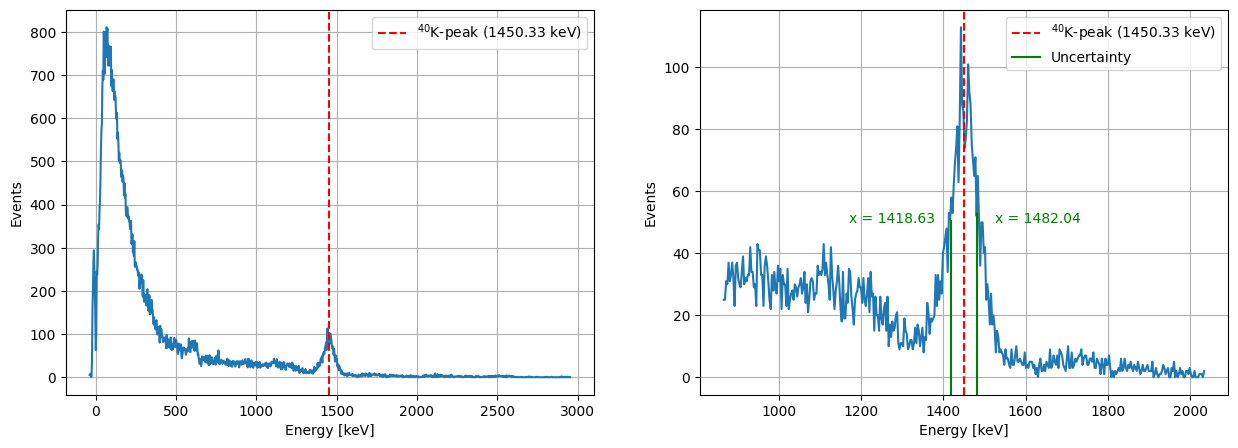

In [14]:
# gamma spektrum plotten
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()

k2co3 = sheets.loc["K2CO3"].iloc[:-1]
axs[0].plot(linear(k2co3.index, *popt), k2co3["Events"])
axs[0].set_xlabel("Energy [keV]")
axs[0].set_ylabel("Events")
axs[0].grid(True)

peak_channel = 508.5
u_peak_channel = 3.7

measured_peak = linear(peak_channel, *popt)
u_measured_peak = linear(peak_channel + u_peak_channel, *popt) - measured_peak

lower_energy = linear(peak_channel - u_measured_peak, *popt)
upper_energy = linear(peak_channel + u_measured_peak, *popt)

# peak
axs[0].axvline(measured_peak, linestyle="--", c="r", label=r"$^{40}$K-peak (" + str(measured_peak.round(2)) + " keV)")
axs[0].legend()
subset = k2co3.loc[peak_channel - 200:peak_channel + 200]

axs[1].plot(linear(subset.index, *popt), subset["Events"])
axs[1].axvline(measured_peak, linestyle="--", c="r", label=r"$^{40}$K-peak (" + str(measured_peak.round(2)) + " keV)")
axs[1].axvline(lower_energy, ymax=0.45, linestyle="-", c="g", label="Uncertainty")
axs[1].axvline(upper_energy, ymax=0.47, linestyle="-", c="g")
axs[1].set_xlabel("Energy [keV]")
axs[1].set_ylabel("Events")
axs[1].legend()
axs[1].grid(True)
axs[1].annotate("x = " + str(np.round(lower_energy, 2)), xy=(1170, 50), c="g")
axs[1].annotate("x = " + str(np.round(upper_energy, 2)), xy=(1525, 50), c="g")

plt.savefig("k2co3_spektrum_ganz.svg")

print(f"uncertainty energy peak: {(upper_energy - lower_energy) / 2}")

lower_energy, upper_energy

<Axes: xlabel='Channel'>

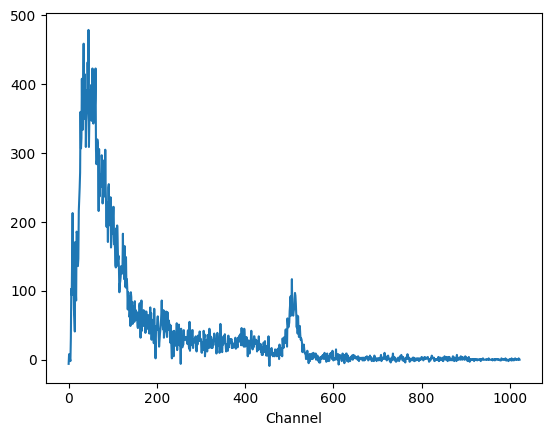

In [16]:
zerfaelle_peak = k2co3["Events"] - (untergrund_ohne_blei - untergrund_mit_blei).iloc[:-1]
zerfaelle_peak.plot()

In [17]:
np.sqrt(zerfaelle_peak.iloc[506-20:506+20].std())

np.float64(4.868913930333457)

In [18]:
zerfaelle_peak.iloc[506-20:506+20].sum()

np.int64(2236)

### Aufgabe 4

In [19]:
m_k2co3 = 100.24 * 1e-3 # in kg
N_0 = 8.7e19

# Aktivität in 1/a
A_k2co3 = N_0 * (np.log(2) / 1.28e9)

# Aktivität in Bq
A_k2co3 * 3.171e-8

np.float64(1493.9325369635626)

## Tschernobylprobe

In [20]:
peaks = pd.DataFrame({"Channels": [36.6, 240.7, 522.9], "Width": [6.0, 2.6, 22.4]}).iloc[1:]
peaks

,Channels,Width
1,240.7,2.6
2,522.9,22.4


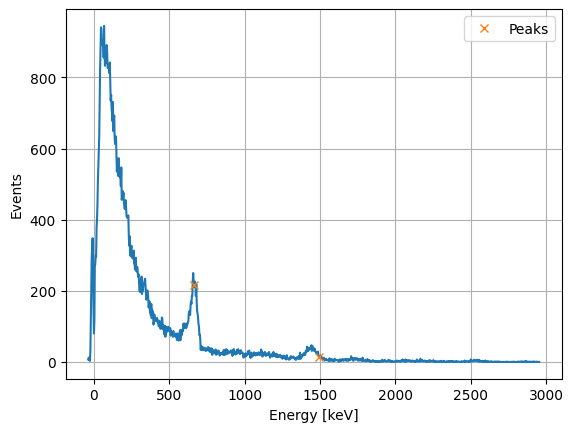

In [23]:
subset = sheets.loc["Melke die Molke"].iloc[:-1]

plt.plot(linear(subset.index, *popt), subset["Events"])
plt.grid(True)
plt.xlabel("Energy [keV]")
plt.ylabel("Events")

plt.plot(linear(peaks["Channels"], *popt), subset.loc[peaks["Channels"].round()]["Events"], "x", label="Peaks")
plt.legend()
plt.savefig("chernobyl_spektrum.svg")

In [24]:
# energy peak uncertainties with gaussian error propagation
m, b, n = symbols("m b n")
formula_e = m * n + b
formula_e

b + m*n

In [25]:
for i, row in peaks.iterrows():
    print(f"peak {i}")
    print(fehler_gauss(formula_e, [m, b, n], [popt[0], popt[1], row['Channels']], [0.1, 0.1, row['Width']]))
    print("-----")

peak 1
(np.float64(666.3931695180962), np.float64(25.24486683378321))
-----
peak 2
(np.float64(1492.48710429634), np.float64(83.86883288051901))
-----


In [26]:
melke = sheets.loc["Melke die Molke"].iloc[20:-1]
melke["Energies"] = linear(melke.index, *popt)
melke

,Events,Energies
Channel,,
20,403,20.330337
21,443,23.257672
22,509,26.185007
23,551,29.112342
24,602,32.039677
...,...,...
1018,0,2941.810659
1019,0,2944.737994
1020,0,2947.665329


In [27]:
energy_10_min_keV = melke["Energies"].dot(melke["Events"])
energy_10_min_J = energy_10_min_keV * 1.60218e-16
energy_1_week_J = energy_10_min_J * 6 * 24 * 7

energy_1_week_J / 75

np.float64(5.416428137722601e-08)

## uran thorium

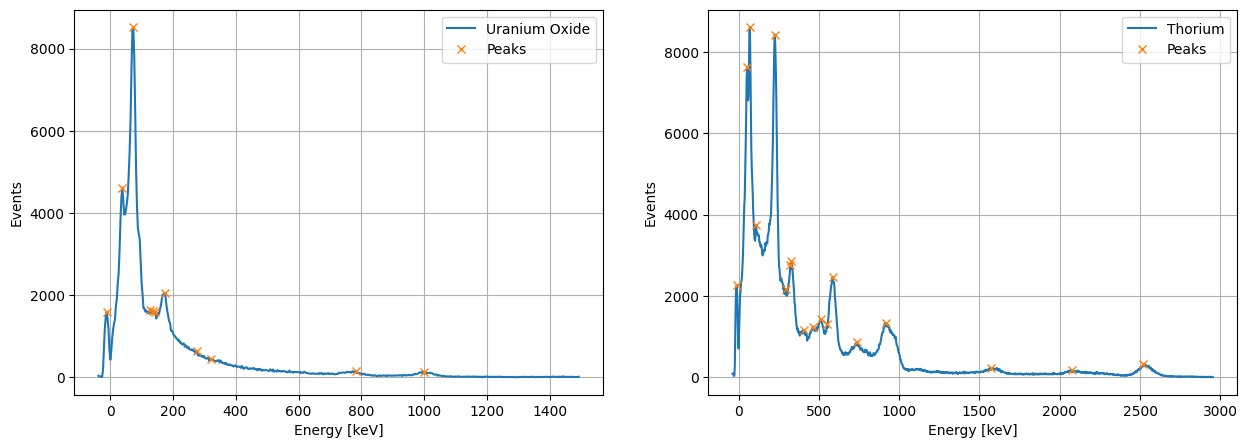

In [28]:
uran = sheets.loc["Uranoxid"].iloc[:-500]
uran_peaks = find_peaks(uran["Events"], prominence=50)[0]
uran_peak_widths = peak_widths(uran["Events"], uran_peaks)[0]

thorium = sheets.loc["Thor"].iloc[:-1]
thorium_peaks = find_peaks(thorium["Events"], prominence=100)[0]
thorium_peak_widths = peak_widths(thorium["Events"], thorium_peaks)[0]

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs = axs.flatten()

axs[0].plot(linear(uran.index, *popt), uran["Events"], label="Uranium Oxide")
axs[0].set_xlabel("Energy [keV]")
axs[0].set_ylabel("Events")
axs[0].plot(linear(uran_peaks, *popt), uran["Events"].iloc[uran_peaks], "x", label="Peaks")
axs[0].grid()
axs[0].legend()

axs[1].plot(linear(thorium.index, *popt), thorium["Events"], label="Thorium")
axs[1].plot(linear(thorium_peaks, *popt), thorium["Events"].iloc[thorium_peaks], "x", label="Peaks")
axs[1].set_xlabel("Energy [keV]")
axs[1].set_ylabel("Events")
axs[1].grid()
axs[1].legend()

plt.savefig("uran_thor_spektrum.svg")

In [29]:
thorium_peaks, u_thorium_peaks = fehler_gauss(
    formula_e,
    [m, b, n],
    [popt[0], popt[1], thorium_peaks],
    [np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1]), thorium_peak_widths],
)

pd.DataFrame({"Energy": thorium_peaks, "Widths": u_thorium_peaks})

,Energy,Widths
0,-11.870348,19.775080
1,52.531022,15.529557
2,70.095032,54.422158
3,108.150387,16.370036
4,225.243786,29.272514
5,292.572491,16.972962
6,321.845841,15.213709
7,327.700511,27.824833
8,409.665891,21.916071
9,465.285256,19.370258


In [30]:
uran_peaks, u_uran_peaks = fehler_gauss(
    formula_e,
    [m, b, n],
    [popt[0], popt[1], uran_peaks],
    [np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1]), uran_peak_widths],
)

pd.DataFrame({"Energy": uran_peaks, "Widths": u_uran_peaks})

,Energy,Widths
0,-11.870348,19.934617
1,37.894347,15.884816
2,73.022367,34.669615
3,125.714396,15.585042
4,134.496401,15.345662
5,143.278406,14.678904
6,172.551756,23.576161
7,275.008481,15.111106
8,321.845841,16.382844
9,781.437435,39.785680


## Hoehenstrahlung

In [300]:
df = pd.read_excel("RAD-Cosmic.xlsx")
df

,Kalibrierung Co-60,Unnamed: 1,Messung,Unnamed: 3
0,Dauer,400 s,Dauer,120 min
1,NaN,NaN,NaN,NaN
2,Kanal,Anzahl,Kanal,Anzahl
3,0,0,0,0
4,1,0,1,0
...,...,...,...,...
1022,1019,0,1019,5
1023,1020,0,1020,1
1024,1021,0,1021,1
1025,1022,1,1022,2


In [301]:
co_channel = df["Kalibrierung Co-60"].iloc[3:]
co_events = df["Unnamed: 1"].iloc[3:]
measurement_channel = df["Messung"].iloc[3:]
measurement_events = df["Unnamed: 3"].iloc[3:]

calibration = pd.Series(co_events.values, index=co_channel.values)
measurement = pd.Series(measurement_events.values, index=measurement_channel.values)

calibration, measurement

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1019    0
 1020    0
 1021    0
 1022    1
 1023    2
 Length: 1024, dtype: object,
 0        0
 1        0
 2        0
 3        1
 4        0
         ..
 1019     5
 1020     1
 1021     1
 1022     2
 1023    36
 Length: 1024, dtype: object)

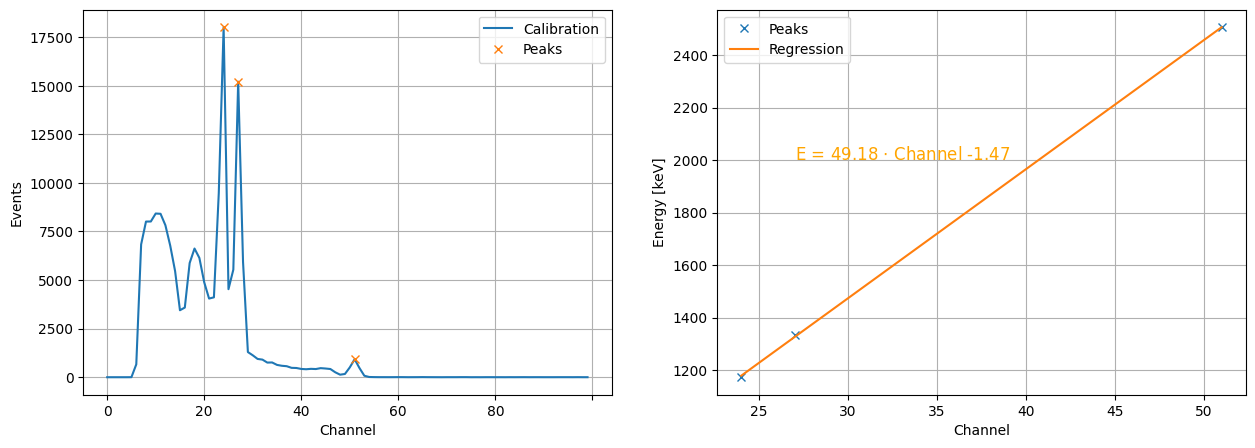

In [314]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs = axs.flatten()

# Eichung
peaks = find_peaks(calibration, prominence=100)
peaks = peaks[0][-3:]

calibration.iloc[:100].plot(ax=axs[0], label="Calibration")
axs[0].plot(peaks, calibration.iloc[peaks], "x", label="Peaks")
axs[0].set_xlabel("Channel")
axs[0].set_ylabel("Events")
axs[0].grid(True)
axs[0].legend()

# lineare regression mit den peaks
popt, pcov = curve_fit(linear, peaks, [1173, 1333, 2506])

Channels = np.arange(peaks.min(), peaks.max()+1, 1)
Energy = linear(Channels, *popt)

axs[1].plot(peaks, [1173, 1333, 2506], "x", label="Peaks")
axs[1].plot(Channels, Energy, label="Regression")
axs[1].set_xlabel("Channel")
axs[1].set_ylabel("Energy [keV]")
axs[1].annotate(r"E = " + f"{popt[0]:.2f}" + r" $\cdot$ Channel " + f"{popt[1]:.2f}", (27, 2000), fontsize=12, c="orange")
axs[1].grid()
axs[1].legend()

plt.savefig("cosmic_rays_calibration.svg")

In [315]:
linear(1000, *popt)

np.float64(49178.89954337899)

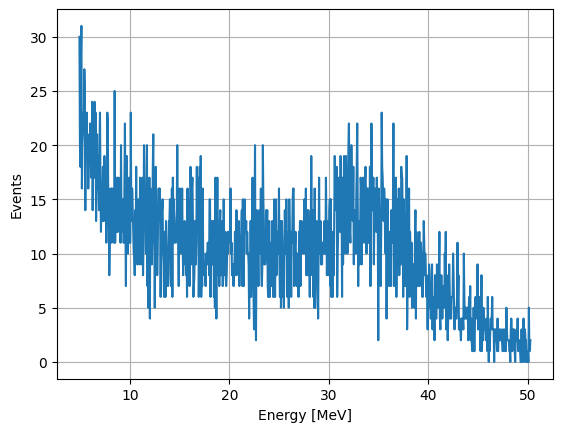

In [317]:
# Messung
subset = measurement[100:-1]
plt.plot(linear(subset.index, *popt) * 1e-3, subset)
plt.xlabel("Energy [MeV]")
plt.ylabel("Events")
plt.grid(True)
plt.savefig("cosmic.svg")

In [28]:
energies = linear(subset.index, *popt) * 1e-3
energies, subset.values

(Index([ 4.916570776255707,   4.96575114155251,  5.014931506849314,
        5.0641118721461185,  5.113292237442922,  5.162472602739726,
         5.211652968036529,  5.260833333333332,  5.310013698630136,
          5.35919406392694,
        ...
         49.81824429223744, 49.867424657534244,  49.91660502283105,
         49.96578538812785, 50.014965753424654,  50.06414611872146,
         50.11332648401826,  50.16250684931507,  50.21168721461187,
         50.26086757990867],
       dtype='object', length=923),
 array([30, 20, 18, 28, 31, 16, 20, 21, 23, 22, 27, 25, 14, 21, 20, 23, 19,
        20, 16, 18, 21, 19, 22, 19, 17, 19, 24, 14, 19, 17, 20, 24, 17, 23,
        13, 16, 21, 16, 19, 17, 14, 20, 23, 16, 12, 15, 13, 16, 18, 13, 13,
        19, 17, 17, 14, 11, 13, 23, 22, 14, 16, 8, 11, 14, 12, 16, 11, 16,
        14, 12, 15, 11, 25, 11, 14, 16, 12, 17, 12, 13, 17, 15, 12, 13, 11,
        20, 12, 13, 13, 15, 11, 11, 17, 22, 13, 7, 16, 19, 12, 10, 12, 16,
        17, 11, 11, 23, 13, 16, 1

In [29]:
energie_2h = energies.values.dot(subset.values) # energie in MeV in 120 min
energie_2h

221679.3426894977

In [30]:
# masse detektorkristall abschätzen
# Volumen (pi * (3 in)^2 * 3 in) in cm^3
V_detektor = 1390
# Masse Detektor
M_detektor = (3.7 * V_detektor) * 1e-3
M_detektor # Masse in kg

5.143

In [318]:
# Aequivalentdosis
energie_2h_joule = energie_2h * 1.60218e-13
energie_2h_joule * 12 * 365 / M_detektor

3.024782260555583e-05